In [1]:
from sklearn.datasets import fetch_20newsgroups 

import re 
import numpy as np
from collections import Counter
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fusemachines/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
cats = ['comp.windows.x', 'sci.crypt', 'talk.politics.mideast']
data = fetch_20newsgroups(categories=cats)

In [3]:
data.target_names

['comp.windows.x', 'sci.crypt', 'talk.politics.mideast']

In [4]:
doc = {}

for i in range(len(data)):
    doc[i] = data['data'][i]

In [5]:
doc

{0: 'From: hovig@uxa.cso.uiuc.edu (Hovig Heghinian)\nSubject: Re: Seventh Century A.D. Armenian Math Problems\nOrganization: University of Illinois at Urbana\nLines: 25\n\nkoc@rize.ECE.ORST.EDU (Cetin Kaya Koc) writes:\n\n>> Problem 1\n>> \n>> My father told me the following story. During the famous wars between the \n>> Armenians and the Persians, prince Zaurak Kamsarakan performed extraordinary\n>> heroic deeds. Three times in a single month he attacked the Persian troops. \n>> The first time, he struck down half of the Persian army. The second time, \n>> pursuing the Persians, he slaughtered one fourth of the soldiers. The third \n>> time, he destroyed one eleventh of the Persian army. The Persians who were \n>> still alive, numbering two hundred eighty, fled to Nakhichevan. And so, from\n>> this remainder, find how many Persian soldiers there were before the  \n> massacre.\n>> \n\n>Answer: a(1-1/2-1/4-1/11)=280 -> a = 1760\n\n>Corollary: Armenians strike, slaughter, destroy, and ma

In [6]:
def process_text(text):
    text = re.sub(r'[^a-zA-Z]+', ' ', text).strip()
    text = text.split(' ')
    text = [w.lower() for w in text]
    text = [w for w in text if not w in stopwords.words("english")]
    text = [w for w in text if len(w) >2]

    return text

In [7]:
vocabulary = [] 

for k, v in doc.items():
    doc[k] = process_text(v)
    vocabulary.extend(doc[k])
    
vocabulary = list(set(vocabulary))
V = len(vocabulary)

In [8]:
D = len(doc)
K = 3

C = np.zeros(D)
N = np.zeros(K)

c = np.zeros((D, K))
n = np.zeros((K, V))

W = []
Z = []

for k, v in doc.items():
    W.append(np.array(v))
    z_i_w = np.array([np.random.choice(K, 1)[0] for i in v])
    Z.append(z_i_w)
    
W = np.array(W)
Z = np.array(Z)

/tmp/ipykernel_16137/1790849546.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  W = np.array(W)
/tmp/ipykernel_16137/1790849546.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  Z = np.array(Z)


In [9]:
def update_variables(c, C, n, N):
    for d, v in doc.items():
        count = Counter(Z[d])
        C_d = 0 
        
        for each_topic in range(K):
            c[d][each_topic] = count[each_topic]
            C_d += count[each_topic]
            
        C[d] = C_d
        
    for each_topic in range(K):
        W_k = []
        
        for d, v in doc.items(): 
            index = np.where(Z[d] == each_topic)[0] 
            
            if len(index) > 0:
                W_k.extend(W[d][index])
                
        count_each_word_in_each_topic = Counter(W_k)
        
        for v in range(V):
            n[each_topic][v] = count_each_word_in_each_topic[vocabulary[v]]
    
        N[each_topic] = len(W_k)

In [10]:
update_variables(c, C, n, N)

### Algorithm LDA

In [11]:
A = 1
B = 1 
total_performance = []

for _ in range(1000):
    performance = [] 


    for d, v in doc.items():
        
        # removed_word: remove data point xi
        for i, removed_word in enumerate(v): 
            
            # remove data point (zi)
            z_word = Z[d][i]  
            
            # find index of removed word in doc d
            index = vocabulary.index(doc[d][i])  
#             print(index, doc[d][i], removed_word)
            

            c[d][z_word] -= 1  # c[document][word index]
            n[z_word][index] -= 1  # n[topic index][word index]
            
            each_topic_prob = [] 
            
            for k in range(K):
                dt_term = (c[d][k] + A/K) / (C[d] + A - 1)

                
                if N[k] == 0:
                    N[k] += 1
                    
                tw_term = (n[k][index] + B/V) / (N[k] + B - 1)
                
                each_topic_prob.append(dt_term * tw_term)
                
            total_prob = np.sum(each_topic_prob)
            performance.append(np.log(np.sum(each_topic_prob)))
            
            each_topic_prob = [p/total_prob for p in each_topic_prob]
            
            sample_topic_for_removed_word = np.random.choice(K, 1, p=each_topic_prob)
            
            Z[d][i] = sample_topic_for_removed_word
            
            # Update variables
            update_variables(c, C, n, N)
    total_performance.append(np.sum(performance))
        

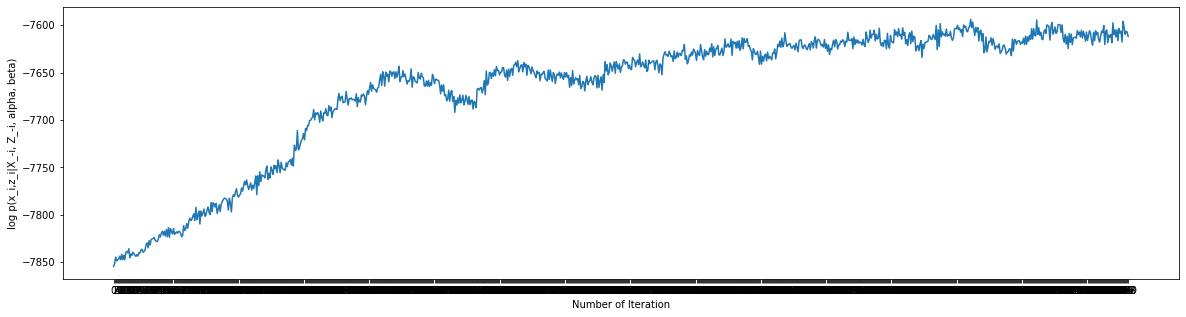

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(total_performance)
plt.xlabel("Number of Iteration")
plt.ylabel("log p(x_i,z_i|X_-i, Z_-i, alpha, beta)")
plt.xticks([i for i in range(len(total_performance))])

plt.show()

### Visualisations  (Document topic dist)

In [13]:
doc_topic_dist = {} 

for d, v in doc.items():
    count_topic_words_in_doc_d = Counter(Z[d])
    total = np.sum(list(count_topic_words_in_doc_d.values()))
    
    # Assigment of each document to topic  
    doc_topic_dist[d] = [count_topic_words_in_doc_d[k]/total for k in range(K)]

Text(0.5, 1.0, 'Document-Topic Distribution')

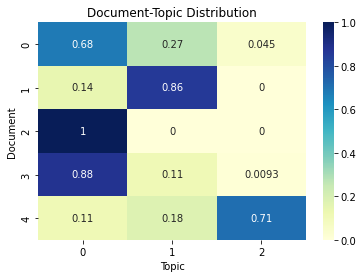

In [14]:
df = pd.DataFrame(doc_topic_dist).T

sns.heatmap(df, annot=True, cmap="YlGnBu")
plt.ylabel('Document')
plt.xlabel('Topic')
plt.title("Document-Topic Distribution")

In [15]:
topic_word_dist = {}

for each_topic in range(K):
    topic_word = [] 
    
    for d, v in doc.items():
        index = np.where(Z[d] == each_topic)[0]
        
        if len(index) > 0:
            topic_word.extend(W[d][index])

    count = Counter(topic_word)
    total = np.sum(list(count.values()))
    
    topic_word_dist[each_topic] = [count[vocabulary[v]]/total for v in range(V)]

In [23]:
df = pd.DataFrame(topic_word_dist).T
df.columns = vocabulary

### Visualisation (Topic Word dist) 

In [24]:
df_tw = df[df.columns[df.max() > 0.015]]

Text(0.5, 1.0, 'Topic-Word Distribution')

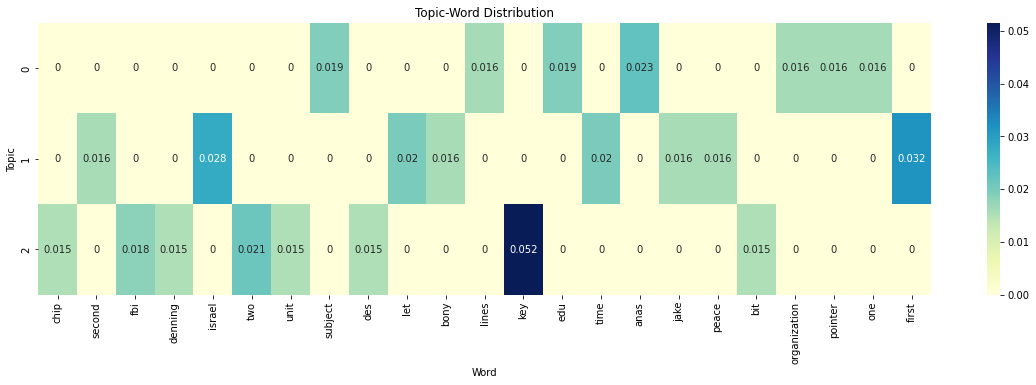

In [25]:
plt.figure(figsize=(20,5))
sns.heatmap(df_tw, annot=True, cmap='YlGnBu')
plt.ylabel('Topic')
plt.xlabel('Word')
plt.title("Topic-Word Distribution")